In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from numpy.random import normal
import time
import os, psutil
from scipy.optimize import curve_fit

In [7]:
### range 100 and 2000 V/cm
def mu(E, T):          # electron mobility  cm^2/s/V   (kV?)
    a0 = 551.6
    a1 = 7953.7
    a2 = 4440.43
    a3 = 4.29
    a4 = 43.63
    a5 = 0.2053
    T0 = 89
    num = a0 + a1*E + a2*(E**(3/2)) + a3*(E**(5/2))
    den = 1 + (a1/a0)*E + a4*(E**2) + a5*(E**3)
    return num/den*((T/T0)**(-3/2))


### range 350 and 2000 V/cm
### effective electron energy
    
def e_eff(E, T):        #in eV
    b0 = 0.0075
    b1 = 742.9
    b2 = 3269.6
    b3 = 31678.2
    num = b0 + b1*E + b2*(E**2)
    den = 1 + (b1/b0)*E + b3*(E**2)
    T1 = 87
    return num/den*(T/T1)

### range 100 and 1500 V/cm
# diffusion in longtutude 
def Dl(E, T):       #cm^2/s
    return mu(E, T)*e_eff(E, T)
    
# diffusion in transverse

def Dt(E, T):       #cm^2/s
    kb = 8.617333262145e-5  ## Boltzmann constant in eV/K
    return kb*T*mu(E, T)
     
def p_l(E, T, dt, num):
    sigma = 2*np.sqrt(Dl(E, T)*dt)
    v_driff = mu(E, T)*E*1e3
    mean = v_driff*dt
    return normal(mean, sigma, num)
    
def p_t(E, T, dt, num):
    sigma = 2*np.sqrt(Dt(E, T)*dt)
    mean = 0
    return normal(mean, sigma, num)    
    
def mc_electron(E, T, dt, tmax, events): 
    start = time.time()
    z = np.zeros([1, events])
    r = np.zeros([1, events])
    t = np.arange(0, tmax, dt)
    i = 0
    while i < len(t)-1:
        dz = p_l(E, T, dt, events)
        dr = p_t(E, T, dt, events)
        # new_z = z[i, :] + dz
        # new_r = r[i, :] + dr
        z = np.vstack([z, z[i, :] + dz])
        r = np.vstack([r, r[i, :] + dr])
        i = i+1
#        if i%500==0:
#            process = psutil.Process(os.getpid())    
#            print('Memory use:', process.memory_info().rss/1024**3)  # in G 
    process = psutil.Process(os.getpid())                 
    end = time.time()
    print(events, 'events, ',len(t), 'times steps' ,', Run time:', end - start, 's')    
    print('Memory use:', process.memory_info().rss/1024**3)  # in G    
    return t, z, r

Text(0,0.5,'v [cm/s]')

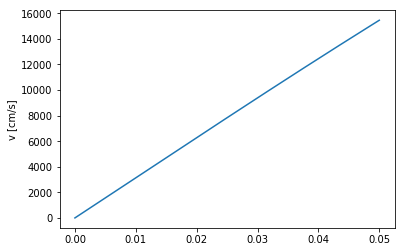

In [8]:
E_v = np.linspace(0, 5e-2, 1000)  ### kV/cm
v_drift = mu(E_v, 130)*E_v*1e3

plt.plot(E_v, v_drift)
plt.ylabel('v [cm/s]')
#print(mu(E_v, 130))

In [11]:
E = 6e-5  ### kV/cm
T = 130  ## K
dt = 1e-4  ##s
tmax = 1.4  ##s
events = 1000
t, z, r =   mc_electron(E, T, dt, tmax, events) 

1000 events,  14000 times steps , Run time: 1577.4922659397125 s
Memory use: 0.28942108154296875


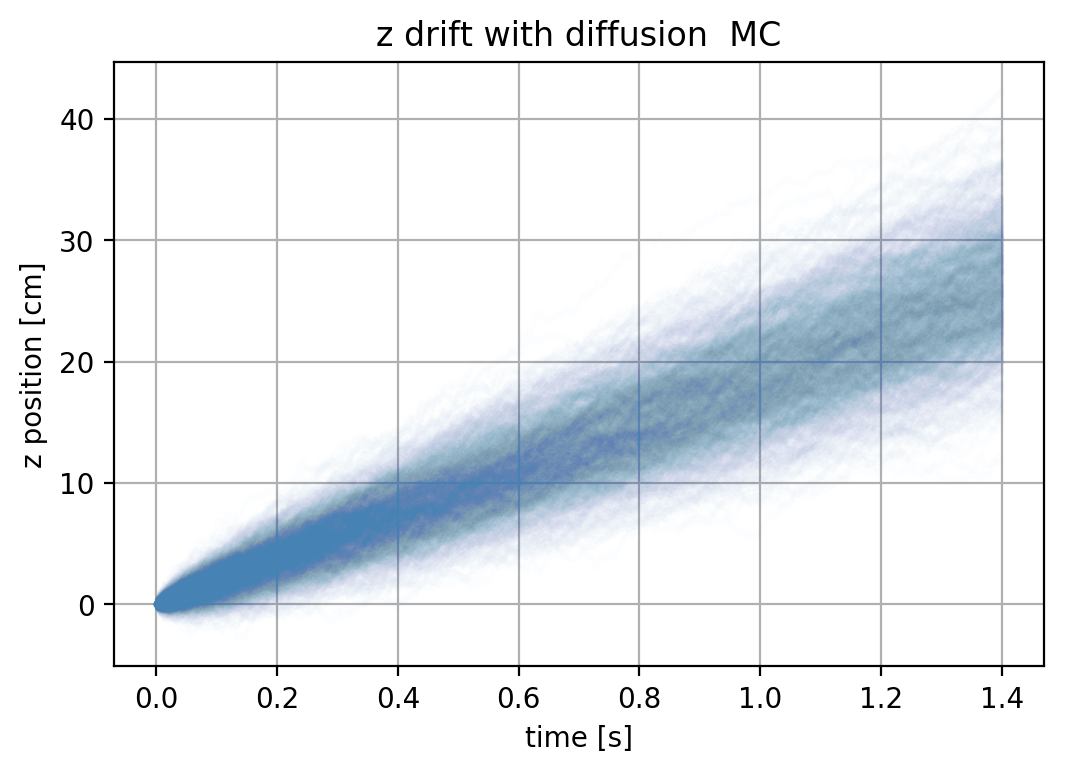

In [22]:
plt.figure(dpi=200)
plt.plot(t, z, color='steelblue', alpha = 0.01)
plt.ylabel('z position [cm]')
plt.xlabel('time [s]')
plt.title('z drift with diffusion  MC')
plt.grid()

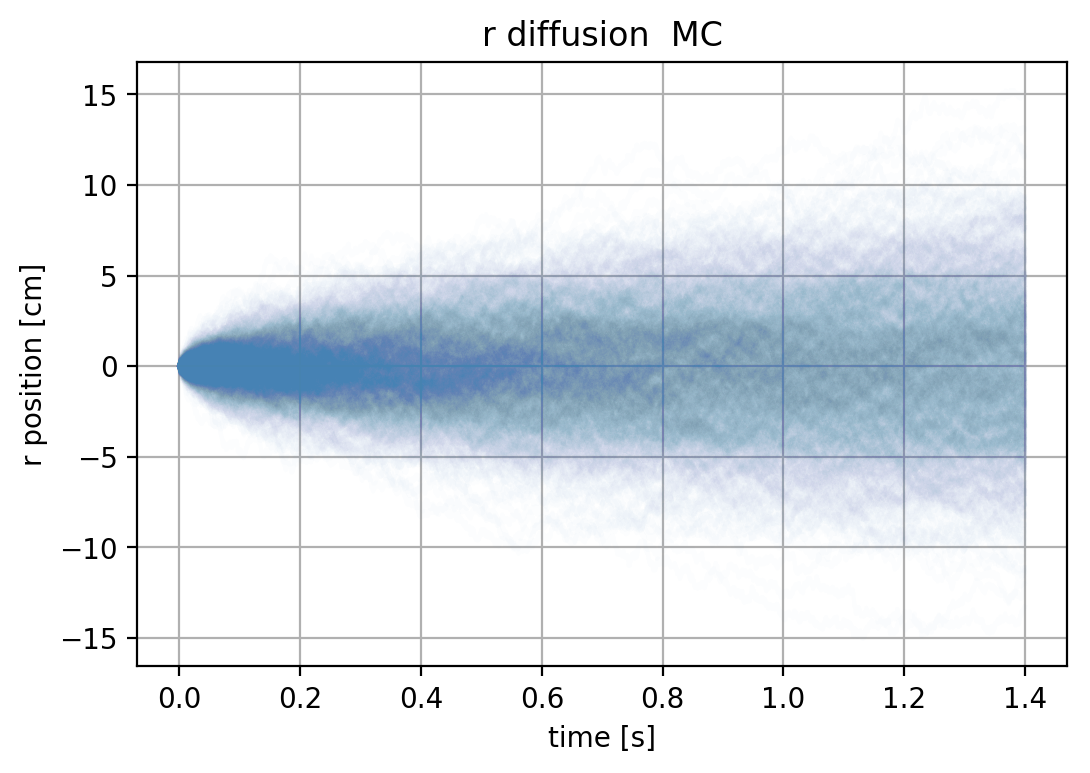

In [21]:
plt.figure(dpi=200)
plt.plot(t, r, color='steelblue', alpha = 0.01)
plt.ylabel('r position [cm]')
plt.xlabel('time [s]')
plt.title('r diffusion  MC')
plt.grid()

mean 18.753053757148056 sigma  3.6001862836334397


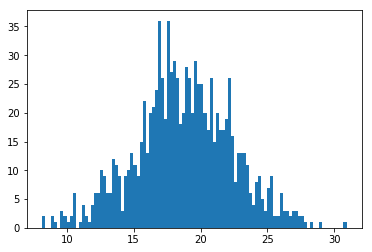

In [7]:
plt.hist(z[-1, :], bins = 100)
z_means = z.mean(axis=1)
z_std = z.std(axis=1)
print('mean', z_means[-1], 'sigma ',z_std[-1])

In [58]:
E5 = 5e-5  ### kV/cm
E7 = 7e-5  ### kV/cm
t, z5, r5 =   mc_electron(E5, T, dt, tmax, events) 
t, z7, r7 =   mc_electron(E7, T, dt, tmax, events) 


1000 events,  14000 times steps , Run time: 1447.3954598903656 s
Memory use: 0.3743553161621094
1000 events,  14000 times steps , Run time: 1453.7049012184143 s
Memory use: 0.5830307006835938


In [59]:
z5_means = z5.mean(axis=1)
z5_std = z5.std(axis=1)
z7_means = z7.mean(axis=1)
z7_std = z7.std(axis=1)

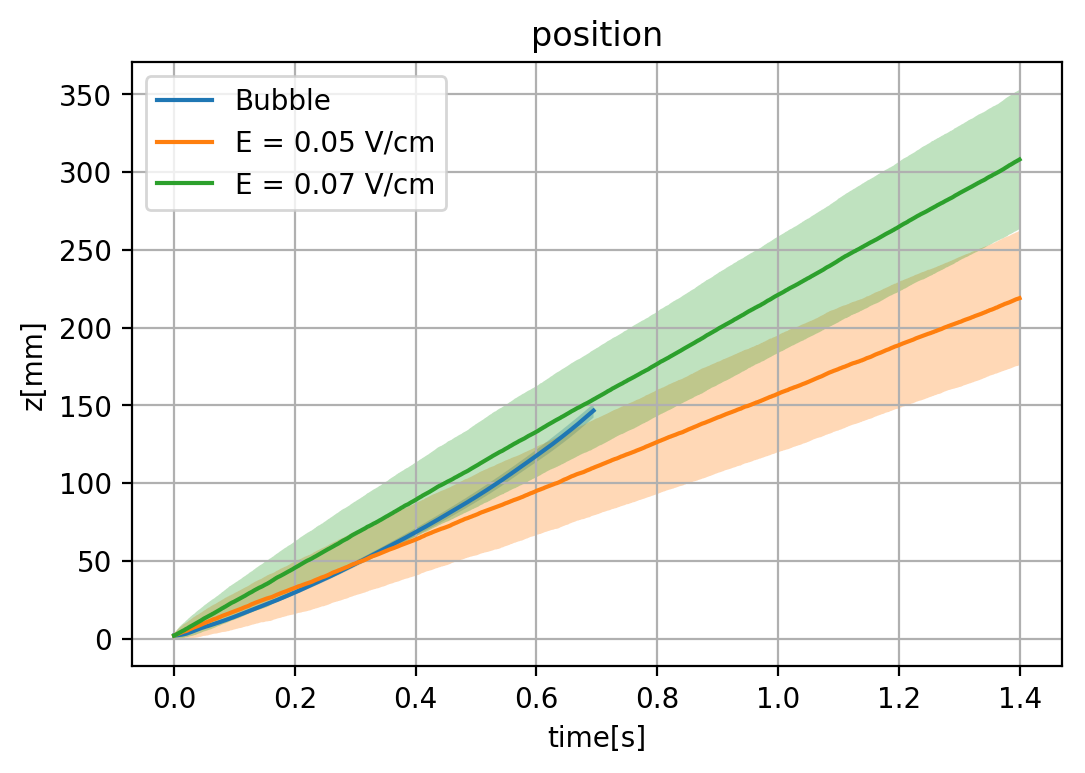

In [61]:
def bubble():
    pos_data = np.loadtxt('pos_time.txt', skiprows=5)

    time = pos_data[0:464, 0]
    pos = pos_data[0:464,1]/pos_data[0:464, 2]

    yax = np.loadtxt('zaxis_time.txt')

    zpos = yax[:, 0]

    low = []
    high = []

    rever = yax[::-1]

    i = 1
    while i < 465:
        low_idx = np.argmax(yax[:, i]>0.4)
        high_idx = len(yax[:, 0]) - np.argmax(rever[:, i]>0.4)-1

        low = np.append(low, zpos[low_idx])
        high = np.append(high, zpos[high_idx])
        i = i+1

    plt.figure(dpi=200)



    plt.plot(time, 0.5*(low+high), label='Bubble')
    plt.fill_between(time, low, high, alpha=0.3)

    pos_func2 = CubicSpline(time, 0.5*(low+high))
    plt.grid()
    plt.title('position')
    plt.ylabel('z[mm]')
    plt.xlabel('time[s]')
bubble()
#plt.plot(t, 2+z_means*10, label='E = 0.06 V/cm')
#plt.fill_between(t, 2+(z_means-z_std)*10, 2+(z_means+z_std)*10, alpha=0.3,label=r'1$\sigma$')
#plt.fill_between(t, 2+(z_means-z_std*2)*10, 2+(z_means+z_std*2)*10, alpha=0.3, color = 'orange',label=r'2$\sigma$')

plt.plot(t, 2+z5_means*10, label='E = 0.05 V/cm')
plt.fill_between(t, 2+(z5_means-z5_std)*10, 2+(z5_means+z5_std)*10, alpha=0.3)

plt.plot(t, 2+z7_means*10, label='E = 0.07 V/cm')
plt.fill_between(t, 2+(z7_means-z7_std)*10, 2+(z7_means+z7_std)*10, alpha=0.3)
plt.legend()




In [62]:
def fifth_order_fit(x, a, b, c, d, e, f):
    return a*x**5 + b*x**4 + c*x**3 + d*x**2 + e*x**1 + f

def bubble():
    pos_data = np.loadtxt('pos_time.txt', skiprows=5)

    time = pos_data[0:464, 0]
    pos = pos_data[0:464,1]/pos_data[0:464, 2]

    yax = np.loadtxt('zaxis_time.txt')

    zpos = yax[:, 0]

    low = []
    high = []

    rever = yax[::-1]

    i = 1
    while i < 465:
        low_idx = np.argmax(yax[:, i]>0.4)
        high_idx = len(yax[:, 0]) - np.argmax(rever[:, i]>0.4)-1

        low = np.append(low, zpos[low_idx])
        high = np.append(high, zpos[high_idx])
        i = i+1

#    plt.figure(dpi=200)

    return low, high, time

#    plt.plot(time, 0.5*(low+high), label='Bubble')
#    plt.fill_between(time, low, high, alpha=0.3)

#    pos_func2 = CubicSpline(time, 0.5*(low+high))
#    plt.grid()
#    plt.title('position')
#    plt.ylabel('z[mm]')
#    plt.xlabel('time[s]')
low, high, ztime  = bubble()

lower_bounds = [-0.001, -0.1, -1, -1000, -1000, 0]
higher_bounds = [0.01, 0.01, 40, 1000, 1000, 3]
popt_zlow, pcov_zlow = curve_fit(fifth_order_fit, ztime, low, bounds = (lower_bounds, higher_bounds))
popt_zhigh, pcov_zhigh = curve_fit(fifth_order_fit, ztime, high, bounds = (lower_bounds, higher_bounds))
print(popt_zlow)
print(popt_zhigh)
print('low error', np.sqrt(np.diag(pcov_zlow)))
print('high error', np.sqrt(np.diag(pcov_zhigh)))

[1.00000000e-02 1.00000000e-02 4.00000000e+01 8.74354151e+01
 1.22866722e+02 2.68055993e-13]
[1.00000000e-02 1.00000000e-02 3.13588141e+01 1.07718305e+02
 1.23770666e+02 2.05932016e+00]
low error [8.85082860e+01 1.54454521e+02 9.72666879e+01 2.66113459e+01
 2.97452085e+00 1.01851348e-01]
high error [5.68531451e+01 9.92135776e+01 6.24791657e+01 1.70938172e+01
 1.91068589e+00 6.54232836e-02]


In [63]:
E50 = 50e-3 ##kV/cm
t, z50, r50 =   mc_electron(E50, T, dt, tmax, events) 
z50_means = z50.mean(axis=1)
z50_std = z50.std(axis=1)

1000 events,  14000 times steps , Run time: 1435.8044695854187 s
Memory use: 0.8576393127441406


Text(0,0.5,'z [mm]')

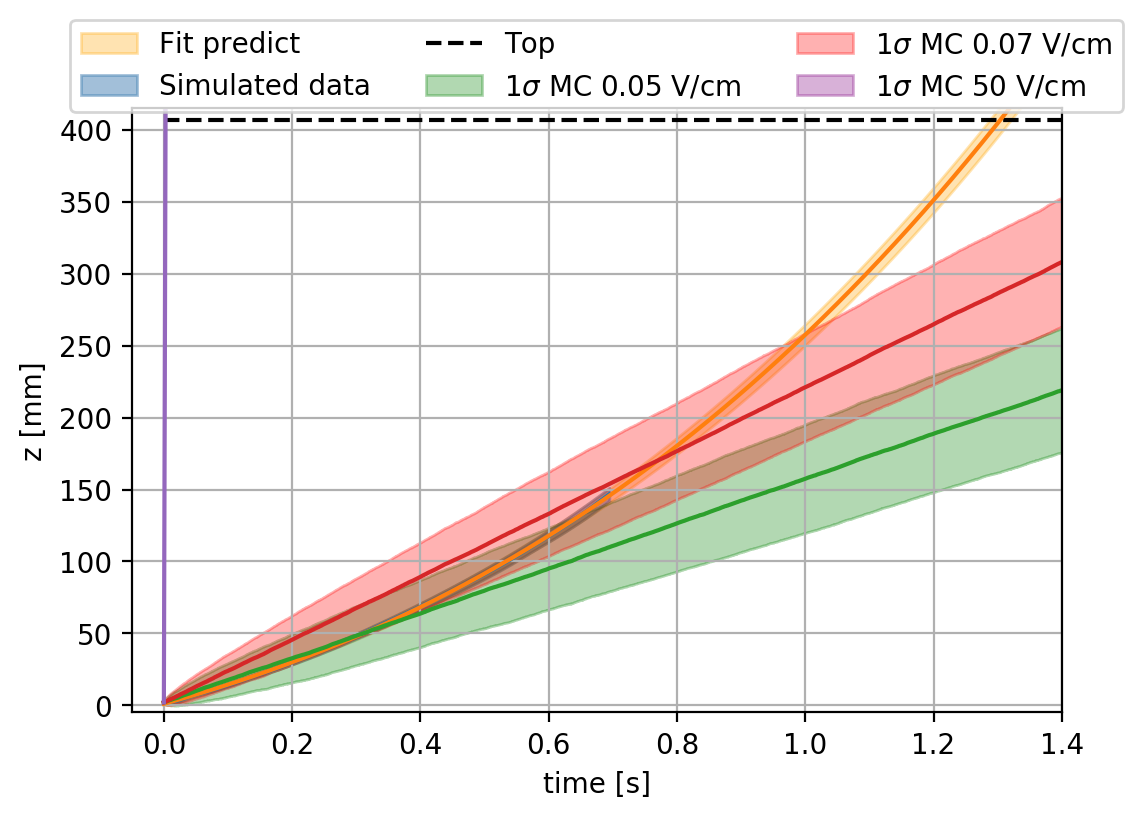

In [64]:
plt.figure(dpi=200)
#plt.plot(ztime, 0.5*(low+high), label='Bubble data')
times = np.linspace(0, 1.5, 1000)

zfit_low = fifth_order_fit(times, popt_zlow[0],popt_zlow[1],popt_zlow[2],popt_zlow[3], popt_zlow[4], popt_zlow[5] )
zfit_high = fifth_order_fit(times, popt_zhigh[0],popt_zhigh[1],popt_zhigh[2],popt_zhigh[3], popt_zhigh[4], popt_zhigh[5] )
plt.fill_between(times, zfit_low, zfit_high, alpha=0.3,  label='Fit predict', color='orange')
plt.plot(ztime, 0.5*(low + high))
plt.plot(times, 0.5*(zfit_low + zfit_high))
plt.fill_between(ztime, low, high, alpha=0.5,  label='Simulated data', color='steelblue')
plt.hlines(407, 0, 1.4, linestyles = 'dashed', label = 'Top' )




plt.plot(t, 2+z5_means*10)
plt.fill_between(t, 2+(z5_means-z5_std)*10, 2+(z5_means+z5_std)*10, alpha=0.3 , color = 'green', label=r'$1\sigma$ MC 0.05 V/cm')

plt.plot(t, 2+z7_means*10)
plt.fill_between(t, 2+(z7_means-z7_std)*10, 2+(z7_means+z7_std)*10, alpha=0.3, color = 'red', label='$1\sigma$ MC 0.07 V/cm')

plt.plot(t, 2+z50_means*10)
plt.fill_between(t, 2+(z50_means-z50_std)*10, 2+(z50_means+z50_std)*10, alpha=0.3 , color = 'purple', label='$1\sigma$ MC 50 V/cm')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.17),
          ncol=3, fancybox=True)
plt.ylim(-5, 415)
plt.xlim(-0.05, 1.4)
plt.grid()
plt.xlabel('time [s]')
plt.ylabel('z [mm]')